In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.utils import resample
import numpy as np

In [2]:
df = pandas.read_csv('/cim/ehoney/ift6168_coding_assignment/simulated_data.csv')

In [3]:
df.head()

,Z1,Z2,W,T,M,Y
0,0.696714,0.064301,0.885308,0,1,0
1,0.061736,0.138900,0.144426,1,1,1
2,0.847689,0.080524,-0.286333,1,0,0
3,1.723030,0.222084,1.819394,1,0,1
4,-0.034153,0.439436,-2.136031,1,1,0


In [4]:
# Z1 = df['Z1'].to_numpy()
# Z2 = df['Z2'].to_numpy()
# W = df['W'].to_numpy()
# T = df['T'].to_numpy()
# M = df['M'].to_numpy()
# Y = df['Y'].to_numpy()

In [5]:
df.describe()

,Z1,Z2,W,T,M,Y
count,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.00000
mean,0.197864,0.202707,-0.118175,0.5956,0.565600,0.48570
std,1.003462,0.200202,1.383609,0.4908,0.495703,0.49982
min,-3.722400,-0.571275,-6.187439,0.0000,0.000000,0.00000
25%,-0.472591,0.067598,-1.038364,0.0000,0.000000,0.00000
50%,0.197405,0.203169,-0.118197,1.0000,1.000000,0.00000
75%,0.871081,0.338773,0.825102,1.0000,1.000000,1.00000
max,4.126238,1.095817,4.877941,1.0000,1.000000,1.00000


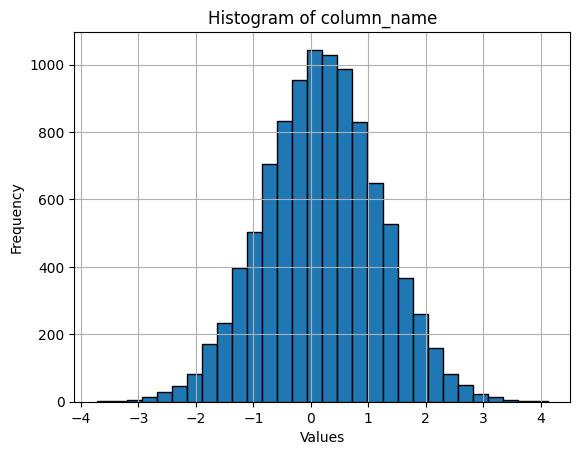

In [40]:
df["Z1"].hist(bins=30, edgecolor="black")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Histogram of column_name")
plt.show()

In [ ]:
sns.pairplot(df, diag_kind="kde")  # Kernel density estimation for diagonal
plt.show()

Choose adjustment set

In [15]:
S = ["Z1", "Z2", "W"]

In [45]:
np.random.SeedSequence()

SeedSequence(
    entropy=108195381233930913037495305369461841746,
)

In [6]:
random_entropy = 108195381233930913037495305369461841746
random_entropy // (10**29)

1081953812

In [7]:
seed_generator = np.random.RandomState(1081953812)

In [8]:
num_bootstraps = 10

In [9]:
random_seeds = seed_generator.randint(0, 10000, size=num_bootstraps)

In [56]:
bootstrap_datasets = {}

for i in range(num_bootstraps):

    seed = random_seeds[i]
    # train = resample(df, replace=True, random_state=seed)
    # test = np.setdiff1d(df, train)

    train = df.sample(n=10000, replace=True, random_state=seed)
    test = df.drop(index=train.index)

    print(len(train), len(test))
    # print(train.head(), test.head())

    bootstrap_datasets[i] = {
        'seed': seed,
        'train': train,
        'test': test
    }

10000 3665
10000 3643
10000 3702
10000 3700
10000 3661
10000 3624
10000 3709
10000 3691
10000 3681
10000 3703


In [57]:
bootstrap_datasets[0]['train'].values == bootstrap_datasets[1]['train'].values

array([[False, False, False,  True,  True,  True],
       [False, False, False,  True, False, False],
       [False, False, False, False,  True, False],
       ...,
       [False, False, False,  True,  True,  True],
       [False, False, False, False, False,  True],
       [False, False, False,  True,  True,  True]], shape=(10000, 6))

In [58]:
ATEs = []

for i in range(num_bootstraps):

    train = bootstrap_datasets[i]['train']
    test = bootstrap_datasets[i]['test']

    model = LinearRegression()
    model.fit(train[S + ['T']], train['Y'])

    test_input_with_treatment = test[S].copy()
    test_input_without_treatment = test[S].copy()

    test_input_with_treatment['T'] = 1
    test_input_without_treatment['T'] = 0

    # print(model.predict(test_input_with_treatment) - model.predict(test_input_without_treatment))
    print(model.coef_[-1])

    ATEs.append(model.coef_[-1])

    # print(model.predict(pandas.concat((treatment_ones, test[S]))) - model.predict(pandas.concat((treatment_zeros, test[S]))))

0.0158980010403781
-0.003978931291922248
0.00435037820762188
-0.0063628086472488354
0.011449456272639758
-0.0002472430884457033
-0.0021470474036826767
0.007216411820348011
0.002231033850927412
0.00398340633830482


In [59]:
ATEs = np.array(ATEs)
print(np.mean(ATEs))
print(np.std(ATEs))

0.0032392657098920517
0.0065707203611336


In [60]:
model = LinearRegression()
model.fit(df[S + ['T']], df['Y'])

LinearRegression()

In [61]:
model.coef_[-1]

np.float64(0.00512779205951993)

In [63]:
model = LinearRegression()
Y_pred = cross_val_predict(model, df[S + ['T']], df['Y'], cv=5)

In [64]:
np.mean(Y_pred)

np.float64(0.4857730545999275)

In [ ]:
scores = cross_val_score(model, S, Y, cv=5, scoring="neg_mean_squared_error")

In [114]:
scores

array([-0.13914527, -0.14032629, -0.13401093, -0.1370503 , -0.12997117])

1. Linear model of effects - use linear regression
2. Nonlinear model of effects - use simple feed-forward neural network
3. Propensity score - use logistic regression

Do 5 fold cross-validation over each to get mean and s.d.

In [116]:
model = LogisticRegression()

In [117]:
model.fit(S, T)

LogisticRegression()

In [136]:
g_pred = cross_val_predict(model, S, T, cv=5, method='predict_proba')[:, 1]

In [137]:
np.mean(Y*T/g_pred - Y*(1-T)/(1-g_pred))

np.float64(0.011025733925202503)

1. Is causal effect the same as ATE? Yes
2. Model of outcomes - E[Y|T and confounders]
3. Model of treatments - P(T|Y) or something?
4. Hyperparameter tuning? Do cross-validation first to select model for (ii), then...
5. Could do bootstrapping (or similar) for mean and SD - see book

In [74]:
IPTWs = []

for i in range(num_bootstraps):

    train = bootstrap_datasets[i]['train']
    test = bootstrap_datasets[i]['test']

    model = LogisticRegression()
    model.fit(train[S], train['T'])

    # test_input_with_treatment = test[S].copy()
    # test_input_without_treatment = test[S].copy()

    # test_input_with_treatment['T'] = 1
    # test_input_without_treatment['T'] = 0

    Y = test['Y']
    T = test['T']
    g_pred = model.predict_proba(test[S])[:, 1]

    first = Y*T/g_pred
    second = Y*(1-T)/(1-g_pred)

    IPTW = np.mean(first - second)
    print(IPTW)
    IPTWs.append(IPTW)

    # print(model.predict(test_input_with_treatment) - model.predict(test_input_without_treatment))

    # ATEs.append(model.coef_[-1])

    # print(model.predict(pandas.concat((treatment_ones, test[S]))) - model.predict(pandas.concat((treatment_zeros, test[S]))))

0.03204068357002925
0.048193170100163996
-0.016995378248336548
0.023511259018794015
0.05331734087296109
-0.029558474580838587
0.01210821264971937
-0.0028942270849448217
0.020090637391617636
0.07073948918170418


In [75]:
IPTWs = np.array(IPTWs)
print(np.mean(IPTWs))
print(np.std(IPTWs))

0.02105527128708696
0.030061106770131102
